## TECHCHALLENGE - Prevendo preços da ação da AMBEV
Esse trabalho consiste em criar 3 modelos preditivos referente ao preço da ação da AMBEV(ABEV3), maior fabricante de bebidas da América latina e uma das maiores do mundo. Foi utilizado o grafico com ticks diários dos ultimos 30 dias (entre maio e junho de 2024) para prever o preço dos próximos 5 dias. Primeiramente foi utilizado um modelo mais simples com média móveis exponenciais, depois testamos o PROPHET e posteriormente partimos para o XGBOOST. 

In [359]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)



### Baixando a ação e o intervalo de tempo pelo yahoo finance


- Considerando que o mercado de ações é "caótico", onde praticamente não existe sazonalidade e tudo pode mudar com um estalar dos dedos, resolvemos utilizar um curto espaço de tempo com 22 dias úteis (1 mês) como base para prever os próximos 5 dias. Focamos apenas na tendencia do preço diário da ação. Utilizamos o yahoo finance para baixar os dados e as bibliotecas numpy, pandas, matplotlib, prophet, xgboost e sklearn.

In [360]:
ticker = 'ABEV3.SA'

# Definindo o ticker e as datas
start_date = '2024-05-21'
end_date = '2024-06-21'

# Baixando os dados históricos
df = yf.download(ticker, start=start_date, end=end_date, interval='1d')

# Definindo o ticker e as datas para comparar com a previsão
start_date_p = '2024-06-21'
end_date_p = '2024-06-28'

# Baixando os dados históricos
df_p = yf.download(ticker, start=start_date_p, end=end_date_p, interval='1d')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [361]:
df.shape

(22, 6)

In [362]:
df.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-05-21,12.10,12.25,12.02,12.02,12.02,38371300
2024-05-22,11.98,12.11,11.93,11.97,11.97,49248200
2024-05-23,11.92,12.07,11.92,11.96,11.96,28419600
2024-05-24,11.96,11.99,11.87,11.87,11.87,22790000
2024-05-27,11.93,11.95,11.79,11.81,11.81,16530500


- Plotando o gráfico abaixo, observa-se uma clara tendencia de baixa com uma possível reversão a partir do dia 13-06-2024

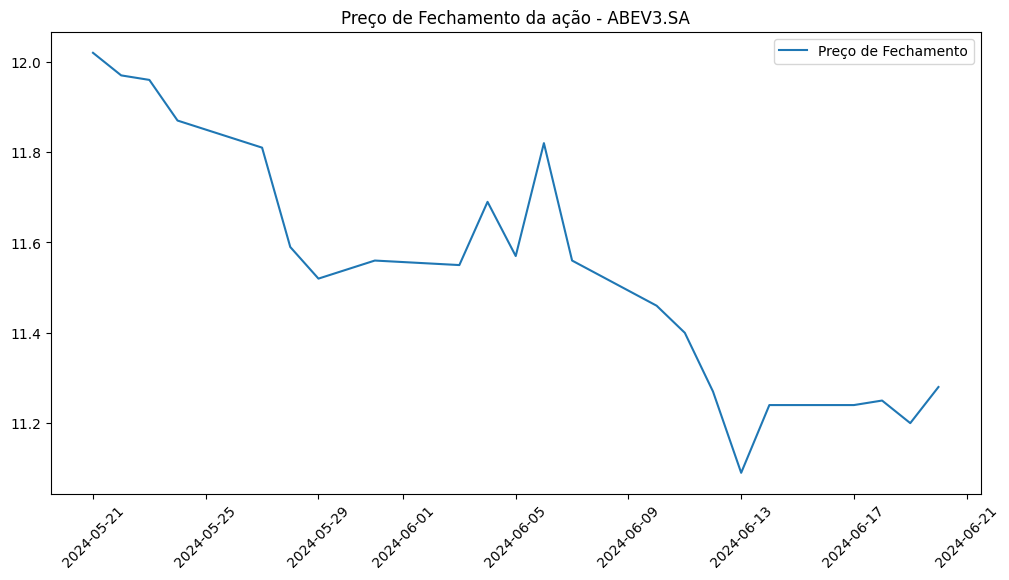

In [363]:
plt.figure(figsize=(12, 6))
plt.plot(df['Close'], label='Preço de Fechamento')
plt.legend()
plt.title(f'Preço de Fechamento da ação - {ticker}')
plt.xticks(rotation=45)
plt.show()

### PREVENDO AÇÕES PELA MÉDIA MÓVEL

- Para prever o valor da ação, criamos uma coluna com a média móvel exponencial (EMA_5) dos ultimos 5 dias, pois assim demos mais peso ao dia mais recente. A partir disso, através da diferença entre o ultimo e o penultimo dia da coluna EMA_5 o algoritmo detecta se há uma tendencia de alta, baixa ou lateral e faz uma previsão linear dos próximos 5 dias. 

In [364]:
# Acrescentando no dataframe a média móvel exponencial (EMA_5) dos últimos 5 dias

df['EMA_5'] = df['Close'].ewm(span=5, adjust=False).mean()
df.tail()

,Open,High,Low,Close,Adj Close,Volume,EMA_5
Date,,,,,,,
2024-06-14,11.09,11.28,10.98,11.24,11.24,22356900,11.294631
2024-06-17,11.21,11.33,11.19,11.24,11.24,18072300,11.276421
2024-06-18,11.19,11.37,11.16,11.25,11.25,37284200,11.267614
2024-06-19,11.18,11.23,11.04,11.20,11.20,17907100,11.245076
2024-06-20,11.25,11.40,11.20,11.28,11.28,29501600,11.256717


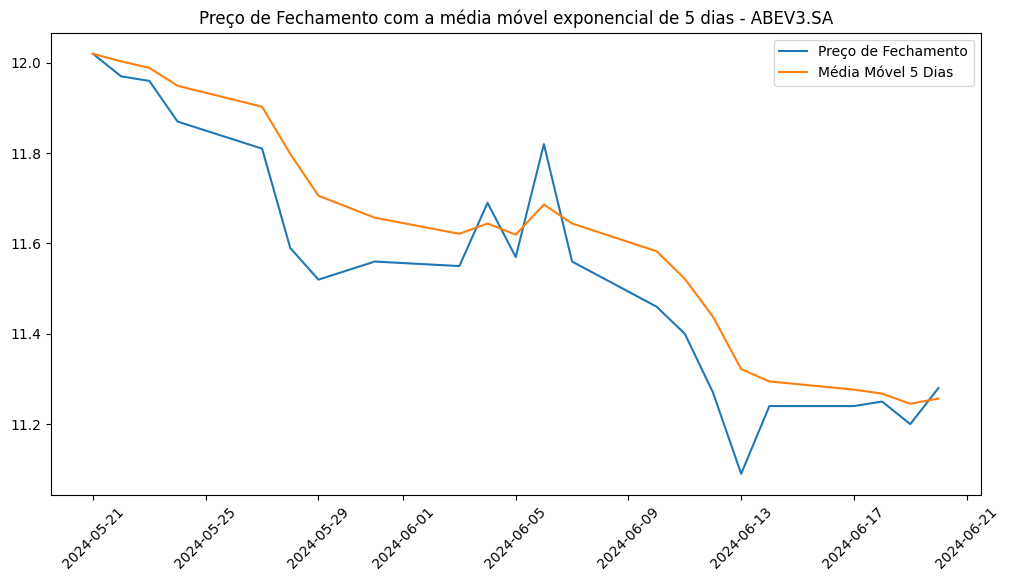

In [365]:
plt.figure(figsize=(12, 6))
plt.plot(df['Close'], label='Preço de Fechamento')
plt.plot(df['EMA_5'], label='Média Móvel 5 Dias')
plt.legend()
plt.title(f'Preço de Fechamento com a média móvel exponencial de 5 dias - {ticker}')
plt.xticks(rotation=45)
plt.show()

In [366]:
# Função para prever os próximos 5 dias
def predict_next_days(df, days=5):
    last_price = df['Close'].iloc[-1]
    ema_5_trend = df['EMA_5'].iloc[-1] - df['EMA_5'].iloc[-2]
    predictions = []

    for i in range(days):
        next_price = last_price + ema_5_trend
        predictions.append(next_price)
        last_price = next_price

    return predictions

# Prevendo os próximos 5 dias
predictions = predict_next_days(df, days=5)

# Gerando datas futuras (somente dias úteis)
next_start_date = pd.bdate_range(start=df.index[-1], periods=2)[-1]
future_dates = pd.bdate_range(start=next_start_date, periods=5)
predicted_df = pd.DataFrame(data=predictions, index=future_dates, columns=['Predicted_Close'])


In [367]:
# Criando um dataframe separado para valor real x previsão
x = df_p.loc[:, 'Close'].tolist()
predicted_df['valor_real'] = x
predicted_df = predicted_df.round(2)
predicted_df

,Predicted_Close,valor_real
2024-06-21,11.29,11.28
2024-06-24,11.30,11.32
2024-06-25,11.31,11.38
2024-06-26,11.33,11.45
2024-06-27,11.34,11.46


- Analisando o resultado abaixo observa-se um bom valor de WMAPE em 0.60%. Podemos também observar através do gráfico plotado um acerto na tendencia altista no preço da ação, mesmo que mais sutil do que ocorreu na realidade.

In [368]:

wmape_mm = np.sum(np.abs(predicted_df['valor_real'] - predicted_df['Predicted_Close'])) / np.sum(np.abs(predicted_df['valor_real'])) * 100
print(f"WMAPE: {wmape_mm:.2f}%")

WMAPE: 0.60%


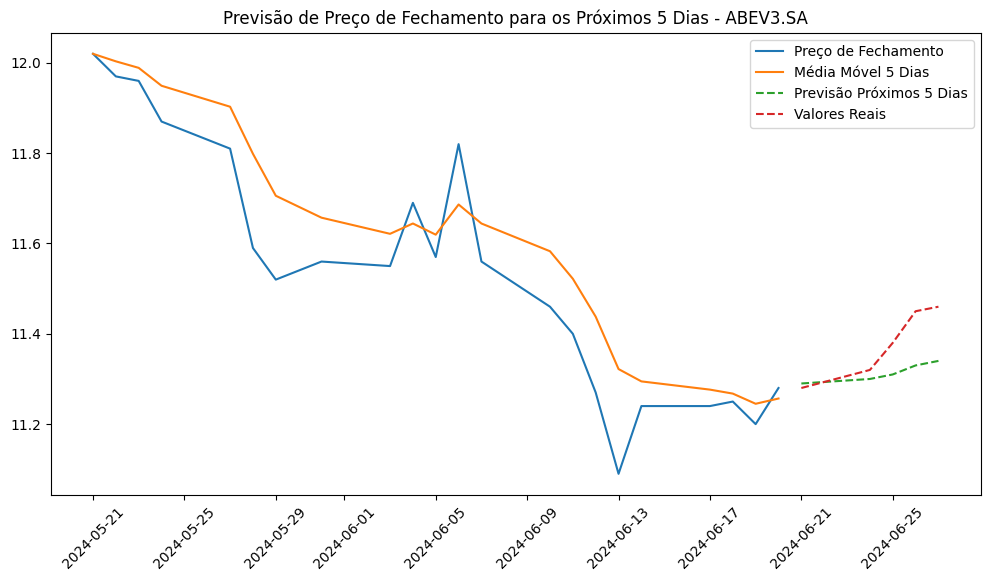

In [369]:

plt.figure(figsize=(12, 6))
plt.plot(df['Close'], label='Preço de Fechamento')
plt.plot(df['EMA_5'], label='Média Móvel 5 Dias')
plt.plot(predicted_df['Predicted_Close'], label='Previsão Próximos 5 Dias', linestyle='--')
plt.plot(df_p['Close'], label='Valores Reais', linestyle='--')

plt.legend()
plt.title(f'Previsão de Preço de Fechamento para os Próximos 5 Dias - {ticker}')
plt.xticks(rotation=45)
plt.show()

### PREVENDO PELO PROPHET

- Decidimos utilizar o Prophet por ser uma modelagem de séries temporais muito utilizada no mercado financeiro. Descartamos do modelo o fator sazonalidade e mantivemos o mesmo intervalo de datas e os 5 dias de previsão do modelo anterior, além disso colocamos como parametro: freq='B' para excluir os finais de semana.

In [370]:
df_prophet = df[['Close']]
df_prophet = df_prophet.reset_index()
df_prophet = df_prophet.rename(columns={'Date':'ds', 'Close':'y'})
df_prophet.head()

,ds,y
0,2024-05-21,12.02
1,2024-05-22,11.97
2,2024-05-23,11.96
3,2024-05-24,11.87
4,2024-05-27,11.81


In [371]:
m = Prophet(daily_seasonality= False)
m.fit(df_prophet)

15:30:00 - cmdstanpy - INFO - Chain [1] start processing
15:30:00 - cmdstanpy - INFO - Chain [1] done processing


In [372]:
future = m.make_future_dataframe(periods=5, freq='B')
future.head()

,ds
0,2024-05-21
1,2024-05-22
2,2024-05-23
3,2024-05-24
4,2024-05-27


In [373]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
22,2024-06-21,11.219221,11.145442,11.295146
23,2024-06-24,11.260526,11.177660,11.350871
24,2024-06-25,11.248975,11.131293,11.357465
25,2024-06-26,11.198585,11.050231,11.340296
26,2024-06-27,11.269301,11.075060,11.465295


In [374]:
prev_5_dias_prophet = forecast[['ds','yhat']].tail()
prev_5_dias_prophet = prev_5_dias_prophet.rename(columns={'ds': 'Date'})
prev_5_dias_prophet = prev_5_dias_prophet.set_index('Date')
prev_5_dias_prophet

,yhat
Date,
2024-06-21,11.219221
2024-06-24,11.260526
2024-06-25,11.248975
2024-06-26,11.198585
2024-06-27,11.269301


- Analisando esse gráfico interativo observa-se um bom acerto considerando que a grande maioria dos dados previstos ficaram dentro do intervalo criado pelo algoritmo do Prophet. 

In [375]:
plot_plotly(m, forecast)

- Analisando o resultado final, temos um WMAPE extremamente baixo de 0.10% indicando um bom acerto na previsão. Refrente ao gráfico, o Prophet preveu uma laterização no preço das ações, enquanto na realidade ocorreu uma alta nesse período.

In [376]:
actuals = df_prophet['y'].values[-5:]
predicted = forecast['yhat'].values[-5:]
wmape_p = sum(abs(actuals - predicted)) / sum(abs(actuals))*100
print(f"WMAPE: {wmape_p:.2f}%")

WMAPE: 0.10%


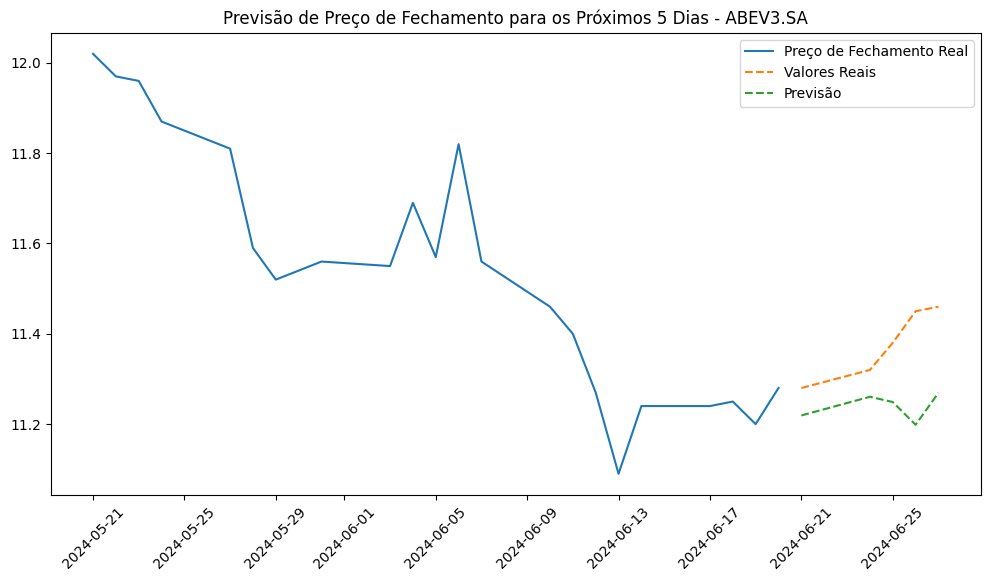

In [377]:
plt.figure(figsize=(12, 6))
plt.plot(df['Close'], label='Preço de Fechamento Real')
plt.plot(df_p['Close'], label='Valores Reais', linestyle='--')
plt.plot(prev_5_dias_prophet['yhat'], label='Previsão', linestyle='--')

plt.legend()
plt.title(f'Previsão de Preço de Fechamento para os Próximos 5 Dias - {ticker}')
plt.xticks(rotation=45)
plt.show()

### - PREVENDO PELO XGBOOST

- Seguindo a dica do professor Daniel que foi dada live do dia 12/7 decidimos testar o XGBOOST para comparar com os outros resultados.

In [378]:
df_xg = df.reset_index(inplace=True)
df_xg = df[['Date', 'Close']]
df_xg.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)
df_xg.head()

,ds,y
0,2024-05-21,12.02
1,2024-05-22,11.97
2,2024-05-23,11.96
3,2024-05-24,11.87
4,2024-05-27,11.81


In [379]:
# Adicionando características de data
df_xg['day'] = df_xg['ds'].dt.day

In [380]:
# Criando defasagens
for lag in range(1, 6):
    df_xg[f'lag_{lag}'] = df_xg['y'].shift(lag)

In [381]:
df_xg.dropna(inplace=True)


In [382]:
df_xg.head()

,ds,y,day,lag_1,lag_2,lag_3,lag_4,lag_5
5,2024-05-28,11.59,28,11.81,11.87,11.96,11.97,12.02
6,2024-05-29,11.52,29,11.59,11.81,11.87,11.96,11.97
7,2024-05-31,11.56,31,11.52,11.59,11.81,11.87,11.96
8,2024-06-03,11.55,3,11.56,11.52,11.59,11.81,11.87
9,2024-06-04,11.69,4,11.55,11.56,11.52,11.59,11.81


In [383]:
# Dividindo em features (X) e target (y)
X = df_xg.drop(columns=['ds', 'y'])
y = df_xg['y']

In [384]:
# Dividindo os dados em treino e teste
train_size = round(df_xg.shape[0] * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [385]:
# Treinando o modelo XGBoost
model = XGBRegressor(n_estimators=100, learning_rate=0.1)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [386]:
# Fazendo previsões
y_pred = model.predict(X_test)

In [387]:
# Fazendo previsões para os próximos 5 dias
last_known_row = X.iloc[-1].values
future_forecast = []
future_dates = pd.date_range(start=df_xg['ds'].iloc[-1] + pd.Timedelta(days=1), periods=5, freq='B')

In [388]:
for i in range(5):
    next_pred = model.predict(last_known_row.reshape(1, -1))[0]
    future_forecast.append(next_pred)
    
    # Atualizando a última linha conhecida com a nova previsão
    last_known_row = np.roll(last_known_row, -1)
    last_known_row[-1] = next_pred

future_forecast = pd.DataFrame({'ds': future_dates, 'y': future_forecast})

- Com o XGBOOST também foi encontrado um excelente resultado do WMAPE com 0.27%. Analisando o gráfico observamos uma previsão que consideramos parcialmente acertada, uma vez que a tendencia prevista inicialmente subiu, mas no terceiro dia lateralizou. Apesar disso consideramos o resultado bastante satisfatório. 

In [389]:
wmape_xg = np.sum(np.abs(y_test - y_pred)) / np.sum(y_test) * 100
print(f"WMAPE: {wmape_xg:.2f}%")

WMAPE: 0.27%


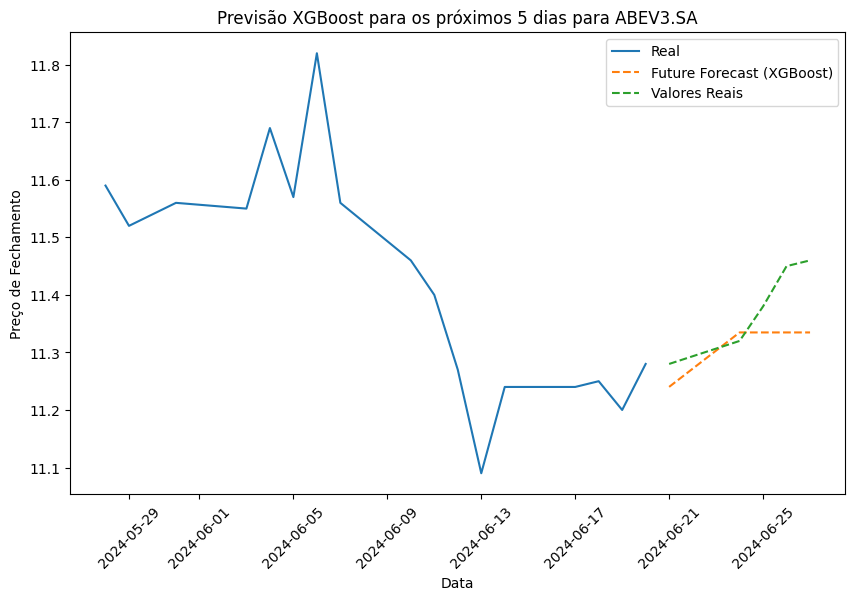

In [390]:
# Visualizando as previsões
plt.figure(figsize=(10, 6))
plt.plot(df_xg['ds'], df_xg['y'], label='Real')
plt.plot(future_forecast['ds'], future_forecast['y'], label='Future Forecast (XGBoost)', linestyle='--')
plt.plot(df_p['Close'], label='Valores Reais', linestyle='--')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.title(f'Previsão XGBoost para os próximos 5 dias para {ticker}')
plt.legend()
plt.xticks(rotation=45)
plt.show()

### Comparando os resultados

- Já sabemos que todos os 3 resultados do WMAPE foram satisfatórios conforme dataframe mostrado abaixo. Mas também plotamos um gráfico com os resultados de todos os modelos previstos compararando com o que realmente ocorreu. E foi muito interessante observar que todos os modelos acertaram que a ação iria subir, uns com mais e outros com menos intensidade.

In [391]:
dfc = pd.DataFrame(

    [wmape_mm.round(2), wmape_p.round(2), wmape_xg.round(2)],
    columns=['WMAPE'],
    index=['Média Móvel','Prophet','XGBOOST']
)
dfc

,WMAPE
Média Móvel,0.60
Prophet,0.10
XGBOOST,0.27


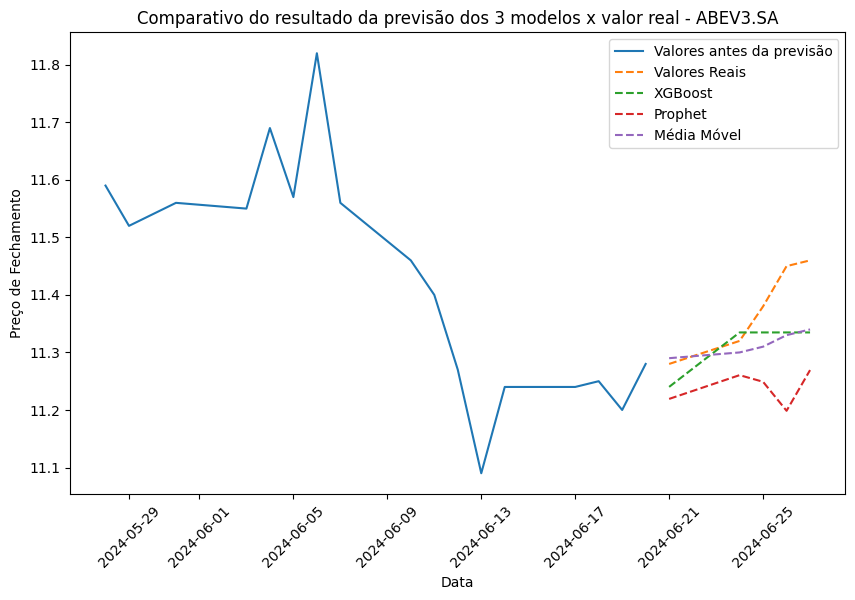

In [392]:
# Visualizando as previsões
plt.figure(figsize=(10, 6))
plt.plot(df_xg['ds'], df_xg['y'], label='Valores antes da previsão')
plt.plot(df_p['Close'], label='Valores Reais', linestyle='--')
plt.plot(future_forecast['ds'], future_forecast['y'], label='XGBoost', linestyle='--')
plt.plot(prev_5_dias_prophet['yhat'], label='Prophet', linestyle='--')
plt.plot(predicted_df['Predicted_Close'], label='Média Móvel', linestyle='--')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.title(f'Comparativo do resultado da previsão dos 3 modelos x valor real - {ticker}')
plt.legend()
plt.xticks(rotation=45)
plt.show()

## Conclusão

Por fim, conforme mencionado no início, o mercado de ações é bastante volátil e muitas vezes imprevisível. Mesmo o mais avançado modelo de machine learning não consegue prever com exatidão o preço futuro das ações. Comparando os 3 modelos, todos tiveram bons resultados, dificultando a escolha de um melhor entre eles. Fizemos testes com outros ativos e em datas diferentes, algumas vezes encontramos resultados parecidos com esse, algumas vezes os 3 modelos erraram, as vezes um foi melhor que outro e vice versa. Quanto ao WMAPE, em todos os testes apresentaram resultados positivos, abaixo de 10%. Mas para chegar a um modelo ideal para prever o preço de uma ação de forma que realmente se invista dinheiro, será necessário bastante estudo, ajuste de parametros, testes, análises estatísticas e etc... 